<a href="https://colab.research.google.com/github/fractalclockwork/Data200/blob/main/Project_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic 1: Computer Vision

In disaster situations, it is important for emergency response efforts to have access to quick and accurate information about an area in order to respond effectively. This project will explore how data science techniques can be useful for such efforts.

Grad project overview: <https://ds100.org/sp24/gradproject/>


Paper on dataset: <https://arxiv.org/pdf/1911.09296.pdf>

Complete dataset: <https://xview2.org/>

Gitrepo: <https://github.com/fractalclockwork/Data200/tree/main>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
COLAB = False

if COLAB:
  import sys
  from google.colab import drive
  # mount colab drive
  drive.mount('/content/drive')

  # add path for colab to see data_utils and feature_utils libraries
  # this sort of defeats the reasoning behind using a JSON config file... oh well
  path = '/content/drive/My Drive/Colab Notebooks/grad_project'
  sys.path.insert(0, path)
else:
  path = '.'

# Loading the data
To get started let's first load in the data! We will make use of the helper functions provided in `data_utils.py`

In [3]:
from data_utils import get_images, get_labels

The following is the list of disasters in our dataset.

In [4]:
disaster_list = ["hurricane-matthew", "socal-fire", "midwest-flooding"]

We will load each disaster train dataset into a dictionary. Recall that each disaster consists of images and labels (0 - 3) of the damage level.

In [5]:
data = {}
split = "train"

with open(f'{path}/config.json') as config_file:
    config = json.load(config_file)
    if COLAB:
      data_dir = config['colab_data_dir']
    else:
      data_dir = config['data_dir']

#data_dir = 'drive/MyDrive/Colab Notebooks/grad_project/data/sp24_grad_project_data/satellite-image-data'

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

Loading train images and labels for hurricane-matthew dataset...
Loading train images and labels for socal-fire dataset...
Loading train images and labels for midwest-flooding dataset...


In [6]:
!tree {path}/{data_dir}

./../data/sp24_grad_project_data/satellite-image-data
├── hurricane-matthew
│   ├── train_images.npz
│   └── train_labels.npy
├── midwest-flooding
│   ├── train_images.npz
│   └── train_labels.npy
├── socal-fire
│   ├── train_images.npz
│   └── train_labels.npy
├── test_images_flooding-fire.npz
└── test_images_hurricane-matthew.npz

3 directories, 8 files


**Observations**

We can see that the files for this dataset have already been split and use the path for disaster type, a file prefix to identify the split(test/train), and a file suffix to indenify datatype(image/label).  Let's run with the code provided however let's also consider how we might develop a Class for our EDA.

# Let's explore our labels to understand their distribution.

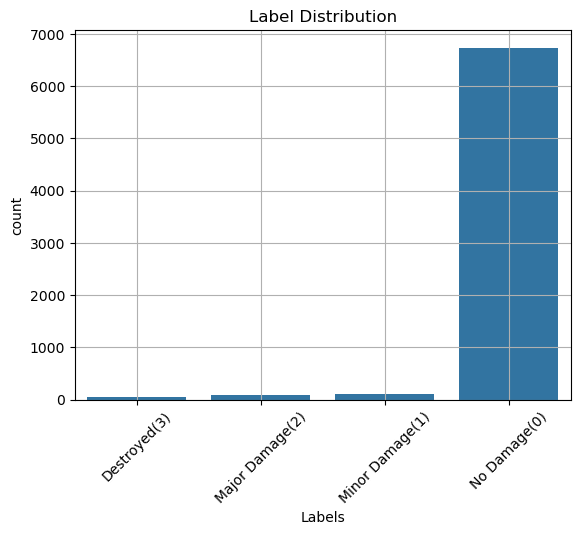

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(labels, columns=['Labels'])
# print(df.describe())

disaster_level = ['No Damage(0)', 'Minor Damage(1)', 'Major Damage(2)', 'Destroyed(3)']
get_disaster_level = lambda x: disaster_level[x]
df['Labels'] = df.map(lambda x: disaster_level[x] )

df = df.groupby('Labels').value_counts().to_frame()
sns.barplot(data=df, x='Labels', y='count')
plt.grid()
plt.xticks(rotation=45)
plt.title('Label Distribution');

**Observations**

We are dealing with a heavily unbalanced dataset.

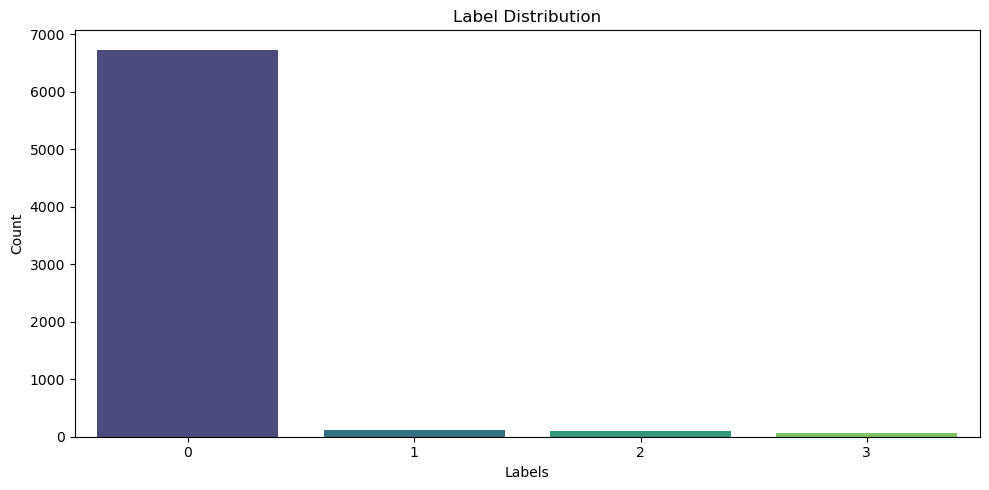

In [8]:
# There's a method provided so let's use that too.
from data_utils import plot_label_distribution
import warnings

warnings.filterwarnings('ignore')
plot_label_distribution(labels)
warnings.filterwarnings('default')

**Observations**

Same results however in ours we map the labels to make them more understandable. Either way we can clearly we are dealing with a heavily unbalanced dataset.

## Let's visualize an image and its label in the dataset.

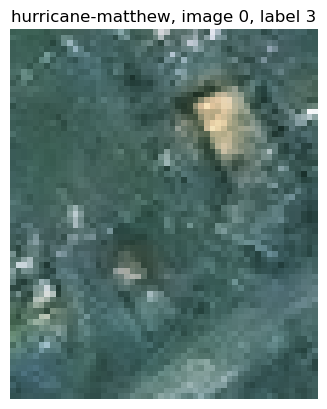

image shape: (65, 54, 3)


In [9]:
disaster = disaster_list[0]
images = data[disaster]["images"]
labels = data[disaster]["labels"]

# index of the image to display
idx = 0
img = images[idx]
label = labels[idx]

plt.title(f"{disaster}, image {idx}, label {label}")
plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.show()

# show shape of image
print(f"image shape: {img.shape}")

# Let's understand the range of image sizes in our dataset

In [10]:
import pandas as pd
from itertools import product

disaster = disaster_list[0]
images = data[disaster]["images"]
labels = data[disaster]["labels"]

# Since we are doing EDA let's use a panda dataframe to collect our results

# Create a list of our dictionaries
data_list = [{'disaster': disaster, 
              'idx': idx, 
              'label': label, 
              'height': img.shape[0], 
              'width': img.shape[1],
              'image_size': img.shape[0] * img.shape[1],
              'img': np.array(img)} 
             for disaster in disaster_list 
             for idx, (img, label) in enumerate(zip(data[disaster]["images"], data[disaster]["labels"]))]

# Convert our list of dictionaries into a DataFrame
df = pd.DataFrame(data_list)
#df['image_size']=df.height * df.width

disaster_regex = r'(fire|hurricane|flood)'
df['disaster_type'] = df['disaster'].str.extract(disaster_regex)

df.head(1)

,disaster,idx,label,height,width,image_size,img,disaster_type
0,hurricane-matthew,0,3,65,54,3510,"[[[58, 94, 83], [60, 97, 86], [61, 98, 86], [6...",hurricane


,min,max,mean
height,3.0,716.0,78.507933
width,3.0,890.0,80.090183
image_size,84.0,410464.0,8169.871867


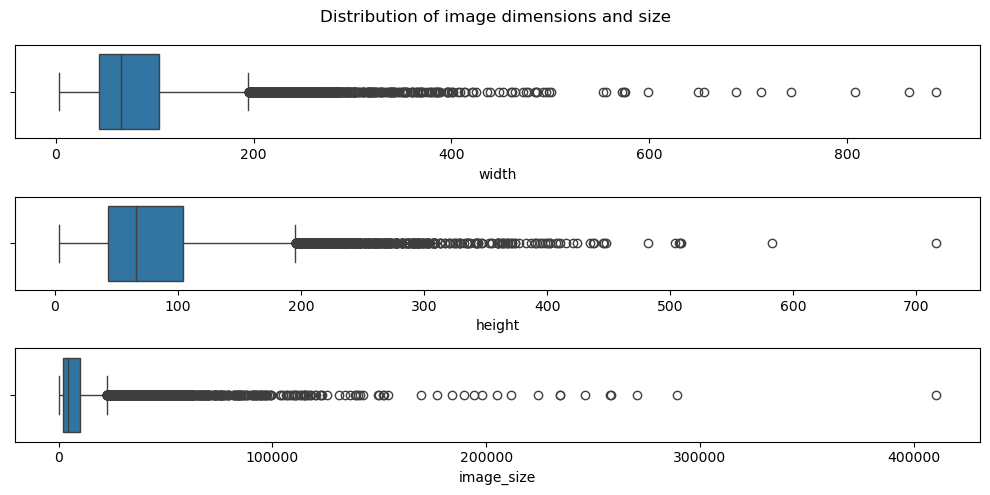

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

display(df.describe()[['height','width','image_size']].T[['min','max','mean']])

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
sns.boxplot(data=df, x="width", ax=ax[0]);
sns.boxplot(data=df, x="height", ax=ax[1]);
sns.boxplot(data=df, x="image_size", ax=ax[2]);

plt.suptitle('Distribution of image dimensions and size')
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()

**Observations**

We can see that there is a wide range of image dimensions and sizes.  From the paper describing the dataset we might expect that larger images show a larger area and that smaller image represent a polygon representing a building.

In [12]:
df.head(1).img.shape

(1,)

len:  16


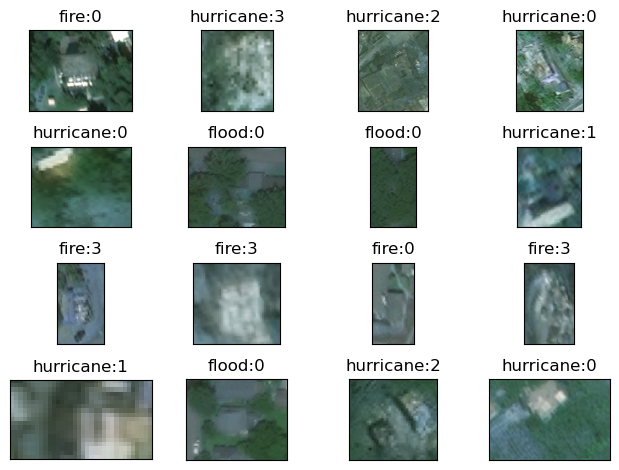

In [13]:
import re

def show_image(img):
    plt.imshow(img.astype(np.uint8))

def show_df(df):
    l = df.shape[0]
    print('len: ', l)
    assert l>0, 'zero length dataframe'

    # plot up to 4x4 images
    if (l > 4):
        rows = l//4
        cols = 4
    else:
        rows = 1
        cols = l
    # print(cols, rows)

    #fig, ax = plt.subplots(rows,cols, figsize=(12,3*rows))
    fig, ax = plt.subplots(rows,cols)
    #print(ax)
    for i, ax in enumerate(ax.flat):
        #display(df.iloc[i])
        img = df.iloc[i].img
        disaster_type = df.iloc[i].disaster_type
        damage = df.iloc[i].label
        ax.imshow(img.astype(np.uint8))
        ax.set_title(f'{disaster_type}:{damage}')
        ax.set_xticks([])  # Disable x ticks
        ax.set_yticks([])  # Disable y ticks
    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()

show_df(df.sample(16))

len:  16


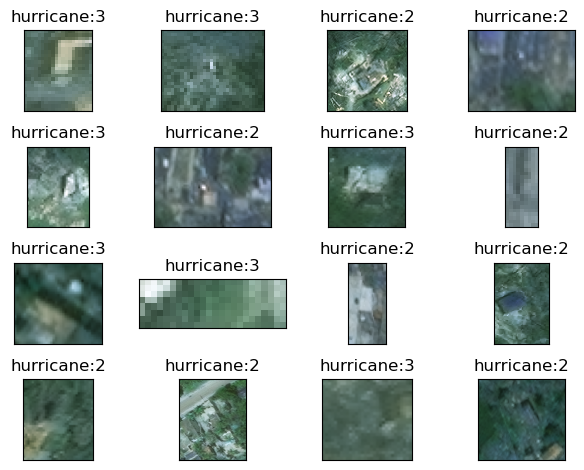

In [14]:
# Now that we had a nice dataframe, let's start exploring these images.
dd = df[(df['label'] > 1) & (df['disaster_type'] == 'hurricane')]
dd = dd.sample(16)
show_df(dd)

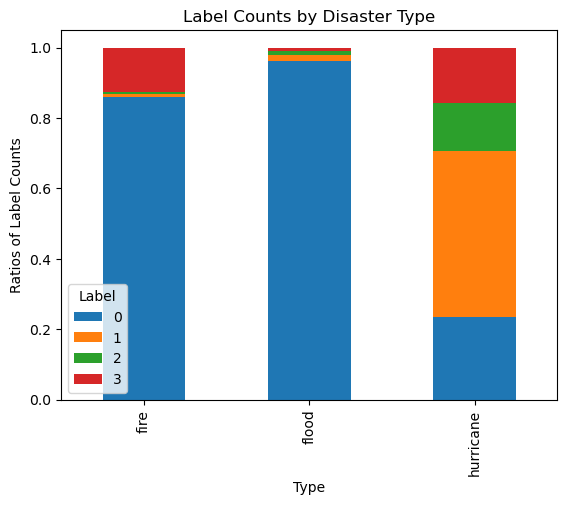

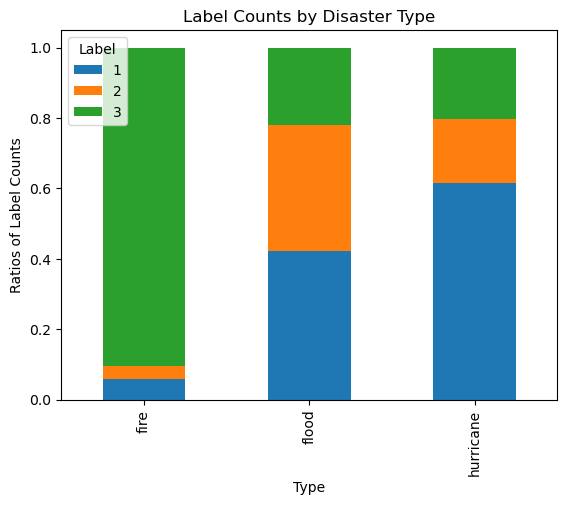

In [24]:
dfs = [df, df[df.label > 0]]
for dd in dfs:
    label_counts = dd.groupby('disaster_type')['label'].value_counts()

    total_counts = label_counts.groupby(level=0).sum()
    label_ratios = label_counts / total_counts

    # Pivot the data for plotting
    pivot_df = label_ratios.unstack(fill_value=0)
    #pivot_df = label_counts.unstack(fill_value=0)
    
    pivot_df.plot(kind='bar', stacked=True)
    plt.xlabel('Type')
    plt.ylabel('Ratios of Label Counts')
    plt.title('Label Counts by Disaster Type')
    plt.legend(title='Label')
    plt.show()

# Extracting Color Information.
Each image is an RGB image represented as a numpy array of dimensions ~~(width, height, 3)~~ (ncols, nrows, 3). The last dimension corresponds to the RGB *color channels* in the image. We can split the image by color channels and visualize each of them individually.

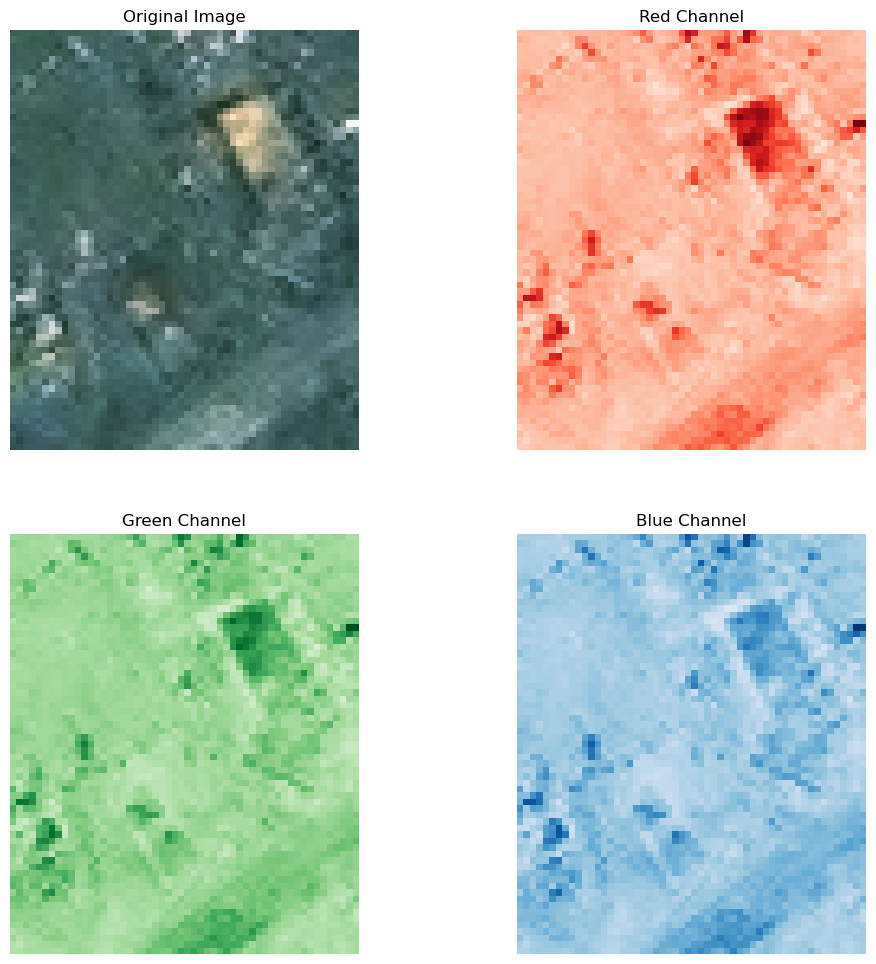

In [16]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img[:, :, 0], cmap="Reds", vmin=0, vmax=255)
plt.title("Red Channel")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img[:, :, 1], cmap="Greens", vmin=0, vmax=255)
plt.title("Green Channel")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(img[:, :, 2], cmap="Blues", vmin=0, vmax=255)
plt.title("Blue Channel")
plt.axis("off")

plt.show()

We can zoom in on just a pixel as well.

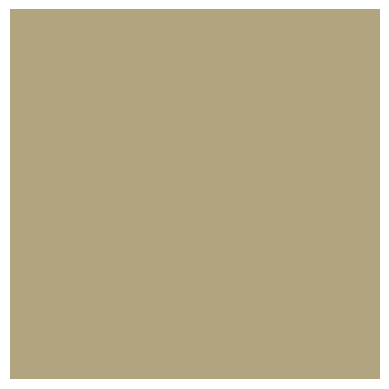

Pixel value: [177 165 128], coordinate: (15, 35)


In [17]:
coord = (15, 35)
pixel_value = img[coord[0], coord[1], :]
pixel_image = np.array([[pixel_value]])

plt.imshow(pixel_image)
plt.axis("off")
plt.show()

print(f"Pixel value: {pixel_value}, coordinate: {coord}")

# Extracting Edge and Texture Information

So far we have considered the **color** information in an image. However, other important aspects of an image are the edges and texture.

Let us consider some popular feature processing methods for extracting edge and texture information. We will use the utilities provided in `feature_utils.py`.

In [18]:
from feature_utils import get_sobel_features, get_gabor_features, generate_gabor_kernel, get_local_binary_pattern

Let's try the Sobel Edge Filter.

Read more about Sobel edge detection: https://en.wikipedia.org/wiki/Sobel_operator and https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html

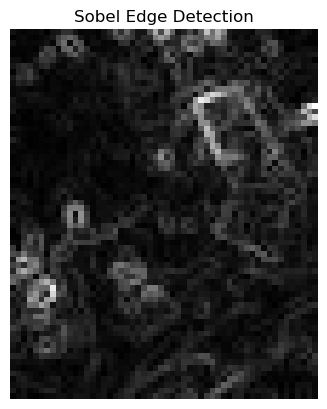

In [19]:
edges = get_sobel_features(img)
plt.imshow(edges, cmap="gray")
plt.title("Sobel Edge Detection")
plt.axis("off")
plt.show()

Now let's look at local binary patterns.

Read more about LBP: https://en.wikipedia.org/wiki/Local_binary_patterns and https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html

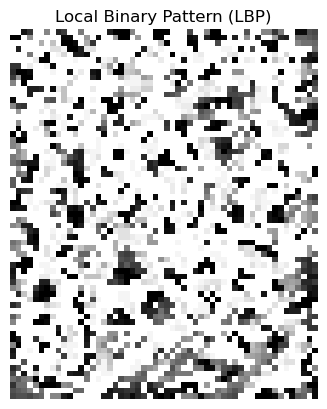

In [20]:
lbp = get_local_binary_pattern(img, radius=3)
plt.imshow(lbp, cmap="gray")
plt.axis("off")
plt.title("Local Binary Pattern (LBP)")
plt.show()

Another popular filter for image processing is the Gabor filter. The Gabor filters are a family of filters parametrized by orientation, frequency, bandwith, etc. Let's generate one such filter.

Read more about Gabor filters: https://en.wikipedia.org/wiki/Gabor_filter and https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html

In [21]:
theta = 0
sigma = 1.0
frequency = 0.1

kernel = generate_gabor_kernel(theta, sigma, frequency)
gabor = get_gabor_features(img, kernel)

Let's visualize this filter (aka kernel) and the response of the image when we apply the filter. Concretely we are taking the convolution of the image with the filter. See https://en.wikipedia.org/wiki/Kernel_(image_processing) for more details.

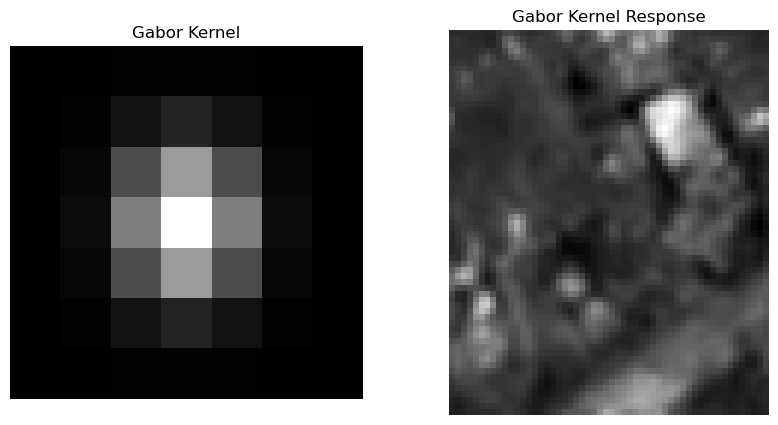

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot Gabor Kernel
axs[0].imshow(kernel, cmap="gray")
axs[0].axis("off")  # Remove axis
axs[0].set_title("Gabor Kernel")

# Plot Gabor Kernel Response
axs[1].imshow(gabor, cmap="gray")
axs[1].axis("off")  # Remove axis
axs[1].set_title("Gabor Kernel Response")

plt.show()

# Appendix 0. Resources


https://ds100.org/sp24/gradproject/

https://xview2.org/

https://www.geeksforgeeks.org/how-to-install-and-use-git-in-google-colab/


# Appendix 1. Project Overview

<h3 id="topic-1-computer-vision">Topic 1: Computer Vision</h3> <p>In disaster situations, it is important for emergency response efforts to have access to quick and accurate information about an area in order to respond effectively. This project will explore how data science techniques can be useful for such efforts.</p> <h4 class="no_toc" id="project-goals">Project Goals</h4> <ul> <li>Learn to work with image data by learning to use common feature extraction techniques like Sobel edge filtering.</li> <li>Learn to work on real-world data with common complexities such as class imbalance, low signal-to-noise ratio, and high dimensional data.</li> <li>Learn how to design effective preprocessing and featurization pipelines for solving difficult machine learning tasks.</li> </ul> <h4 class="no_toc" id="mission">Mission</h4> <p>You have been hired by a crisis response agency to help assist them with your impressive data science skills! The agency has found that using satellite imagery is highly useful for supplying information for their response efforts. Unfortunately, however, annotating these high-resolution images can be a slow process for analysts. Your mission is to help address this challenge by developing an automatic computer vision approach!</p> <h4 class="no_toc" id="dataset-description">Dataset Description</h4> <p>The agency would like you to develop your approach on their internal dataset, derived from the <a href="https://xview2.org/" target="_blank">xView2 Challenge Dataset</a>. This dataset contains satellite images of buildings after various natural disasters. The buildings are labeled based on the level of damage sustained on a scale ranging from 0 (no damage) to 3 (destroyed).</p> <p>You can access all of the data within the <code class="language-plaintext highlighter-rouge">./satellite-image-data</code> directory. The dataset consists of the following folders for different natural disasters</p> <ol> <li><code class="language-plaintext highlighter-rouge">midwest-flooding</code></li> <li><code class="language-plaintext highlighter-rouge">socal-fire</code></li> <li><code class="language-plaintext highlighter-rouge">hurricane-matthew</code></li> </ol> <p>Within each folder is a zip file <code class="language-plaintext highlighter-rouge">train_images.npz</code> containing the satellite images as numpy arrays and a <code class="language-plaintext highlighter-rouge">train_labels.npy</code> file with corresponding damage level labels.</p> <blockquote> <p>Testing: In the main directory, there are also the <code class="language-plaintext highlighter-rouge">test_images_hurricane-matthew.npz</code> and <code class="language-plaintext highlighter-rouge">test_images_flooding-fire.npz</code> zip files. The first contains test images from the <code class="language-plaintext highlighter-rouge">hurricane-matthew</code> disaster and the latter consists of a combination of test images from <code class="language-plaintext highlighter-rouge">midwest-flooding</code> and <code class="language-plaintext highlighter-rouge">socal-fire</code>.</p> </blockquote> <h4 class="no_toc" id="getting-started">Getting Started</h4> <p>To help you with onboarding, the agency has provided a starter notebook <a href="https://data100.datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FDS-100%2Fsp24-student&amp;urlpath=lab%2Ftree%2Fsp24-student%2Fgrad-proj%2Fcv-satellite-images%2Fstarter.ipynb&amp;branch=main" target="_blank"><code class="language-plaintext highlighter-rouge">starter.ipynb</code></a> which will introduce you to the dataset and some useful internal tools. After completing the onboarding assignment you will be comfortable with the following:</p> <ol> <li>Loading and visualizing data using tools from <code class="language-plaintext highlighter-rouge">data_utils.py</code></li> <li>Processing different color channels in the dataset images.</li> <li>Extracting feature information from images using tools from <code class="language-plaintext highlighter-rouge">feature_utils.py</code>.</li> </ol> <h4 class="no_toc" id="exploratory-data-analysis">Exploratory Data Analysis</h4> <p>Now that you have successfully been onboarded, the agency would like you to start performing some exploratory data analysis to build an initial understanding of the data. As part of the exploratory data analysis, the agency is interested in understanding certain aspects of the dataset better. Specifically, they are looking for:</p> <ul> <li>Basic statistics about the dataset, such as the number of images per disaster type and the distribution of image sizes and damage labels.</li> <li>Insights into useful image features for classifying images based on disaster type or damage level. Previous interns have found color information to be potentially useful. You are tasked with verifying this and exploring whether color features can effectively differentiate: <ul> <li><code class="language-plaintext highlighter-rouge">midwest-flooding</code> from <code class="language-plaintext highlighter-rouge">socal-fire</code> images.</li> <li>Damage levels 1 and 3 within the <code class="language-plaintext highlighter-rouge">hurricane-matthew</code> dataset.</li> </ul> </li> </ul> <p>Please prepare an EDA report to present to the agency leadership with the above in mind.</p> <h4 class="no_toc" id="project-tasks">Project Tasks</h4> <p>Now that leadership is pleased with your initial EDA report and confident in your data science ability, they would like you to assist the agency with various tasks. <em>Please complete Task A first and then Task B.</em></p> <h4 class="no_toc" id="task-a-disaster-type-classification"><em>Task A: Disaster Type Classification</em></h4> <p>The agency consists of different subdivisions for assisting with different disaster types, e.g., fires, floods, etc. In the event of a disaster, the agency mounts its response effort by first assessing the type of disaster and then requesting the appropriate subdivision to assist with the disaster.</p> <p>Your task is to assist the agency with making this initial call quickly by automatically classifying images based on the disaster scenario. Specifically, your role will be to build a classifier that can distinguish images from the <code class="language-plaintext highlighter-rouge">midwest-flooding</code> disaster and the <code class="language-plaintext highlighter-rouge">socal-fire</code> disaster.</p> <p>To assess your performance, please submit predictions for the <code class="language-plaintext highlighter-rouge">test_images_flooding-fire.npz</code> images. This should be in a csv file <code class="language-plaintext highlighter-rouge">test_images_flooding-fire_predictions.csv</code> consisting of a single column with no header, with a 0 to indicate a <code class="language-plaintext highlighter-rouge">midwest-flooding</code> prediction and a 1 to indicate a <code class="language-plaintext highlighter-rouge">socal-fire</code> prediction. The prediction in row <em>i</em> should correspond to the <em>ith</em> image.</p> <h4 class="no_toc" id="task-b-damage-level-classification"><em>Task B: Damage Level Classification</em></h4> <p>The agency needs to know how severe a disaster is in order to allocate resources for a response effectively. The agency is especially concerned with human lives and uses building damage as an important metric for disaster severity.</p> <p>Your task is to assist the agency by automatically detecting the building damage level after a disaster. Specifically, create a damage level classifier for the <code class="language-plaintext highlighter-rouge">hurricane-matthew</code> disaster.</p> <p>To assess your performance, please submit predictions for the <code class="language-plaintext highlighter-rouge">test_images_hurricane-matthew.npz</code> images. This should be in a CSV file <code class="language-plaintext highlighter-rouge">test_images_hurricane-matthew_predictions.csv</code> consisting of a single column with no header, with a 0-3 prediction of the damage level. The prediction in row <em>i</em> should correspond to the <em>i</em>th image.</p> <h4 class="no_toc" id="resources">Resources</h4> <p>To assist you in your efforts the agency has compiled the following list of resources:</p> <ul> <li>For more background about the dataset you can look at the <a href="https://arxiv.org/pdf/1911.09296.pdf" target="_blank">paper</a> associated with the dataset.</li> <li>For image processing, <a href="https://scikit-image.org/" target="_blank">scikit-image</a> is a very useful library. This <a href="https://www.kaggle.com/code/bextuychiev/full-tutorial-on-image-processing-in-skimage" target="_blank">tutorial</a> may be helpful for learning how to use the library.</li> <li>For problems with imbalanced classes, the <a href="https://imbalanced-learn.org/stable/index.html" target="_blank">imblearn</a> library has useful tools and examples.</li> </ul>

# Appendix 2. Deliverables

<h2 id="group-formation--research-proposal">Group Formation + Research Proposal</h2> <p>The first deliverable of your group project is just to form your group, choose a dataset, and submit your implementation plan to <a href="https://forms.gle/DcBp3ZbM8TpTfSRD6" target="_blank">this google form</a> by 11:59 pm on 3/15. The implementation plan should consist of a series of steps for completing the project along with a timeline. You may form groups of 2 or 3 people with any Data 200/200A/200S student.</p> <!-- ## Checkpoint 1: EDA + Internal Peer Review The checkpoint is intended to keep you on track to meet your project goals. You will need to submit exploratory data analysis results on Gradescope. This will include submitting both a report of your results so far as well as all code necessary to replicate your results. Your submission should include: - **Project Introduction and Goals:** Please briefly introduce your project. Think about introducing your project to someone who has a background in data science but does not know the dataset and your research question. This part should not exceed 500 words. Here are some components to help you get started: - What is the dataset about? How was the data collected? What are the available features and information? What is the size of the dataset? - What questions do you plan to ask about the dataset? Why do we care about such a problem? - What is your workflow for the project? Your first step, second step… - What are the models you plan to use? Why would the model be a good fit for your project? What are potential pitfalls you could run into? - What is your goal for the project? What are the expected deliverables? - **EDA:** Show the results from your EDA work. You should include: - **Data Sampling and Collection** - How was the data collected? - Was there any potential bias introduced in the sampling process? - **Data Cleaning** - What type of data are you currently exploring? - What is the granularity of the data? - What does the distribution of the data look like? Are there any outliers? Are there any missing or invalid entries? - **Exploratory Data Analysis** - Is there any correlation between the variables you are interested in exploring? - How would you cleanly and accurately visualize the relationship among variables? - What are your EDA questions? (For example, are there any relationships between A and B? What is the distribution of A?). - Do you need to perform data transformations? - **Figures(tables, plots, etc.)** - Descriptions of your figures. Takeaways from the figures. - These figures must be of good quality (i.e. they must include axes, titles, labels, etc) and they must be relevant to your proposed analysis. - **Other Preliminary Results (optional)**: Please optionally post any other preliminary results here for our information. ## Checkpoint 2: Mandatory Check-In The purpose of this checkpoint is to ensure you are making progress and on schedule to submit the first draft of the project in 2 weeks time. You will be required to make a one-page document summarizing all of your progress so far, and you will have to bring the document to a one-on-one meeting with a staff member. Please look at the <a href="#checkpoint-2-mandatory-check-in-75">rubric</a> for the checkpoint and what you need to include in the <a href="#final-project-report">Final Project Report</a> when determining what to include in your one-page document; the document should be a brief summary of all your progress so far. The staff member will quickly skim the document and give you guidance on the project as a whole. More details about submitting the one-page document and signing up for the staff member meeting will be announced on Ed soon. <!-- ## Final Project Report The project submission should include the following two components, as well as the YouTube video recording (more information to be announced later). --> <!-- ### [Component 1] Analysis Notebooks This component includes all the Jupyter Notebook(s) containing all the analyses that you performed on the datasets to support your claims in your write-up. Make sure that all references to datasets are done as `data/[path to data files]`. By running these notebooks, we should be able to replicate all the analysis/figures done in your write-up. Your analysis notebook(s) should address all of the following components in the data science lifecycle. Please note that a thorough explanation of your thought process and approach is **as important as** your work. Unreadable/uncommented code will lose points. Along with the code for the EDA portion (which also has to be included), we have provided a few additional preliminary questions/tips you can consider for the modeling portion of the project: - What are the research questions that you are answering through your analysis? What type of machine learning problem are you investigating? - Which model(s) do you use and why? - How do you use your data for training and testing? - Does your model require hyperparameter tuning? If so, how do you approach it? - How do you engineer the features for your model? What are the rationales behind selecting these features? - How do you perform cross-validation on your model? - What loss metrics are you using to evaluate your model? Why? - From a bias-variance tradeoff standpoint, how do you assess the performance of your model? How do you check if it is overfitting? - How would you improve your model based on the outcome? - Are there any further extensions to your model that would be worth exploring? ### [Component 2] Project Write-Up This is a single PDF that summarizes your workflow and what you have learned. It should be structured as a research paper and include a title, list of authors, abstract, introduction, description of data, methodology, summary of results, discussion, conclusion, and references. Make sure to number figures and tables, include informative captions, and ensure you include the provenance of the figures in the main narrative. We encourage you to render the PDF using LaTeX, but we will not be able to provide assistance with LaTeX-related issues. Specifically, you should ensure you address the following in the narrative: * Clearly state the research questions and why they are interesting and important. * Introduction: ensure you include a brief survey of related work on the topic(s) of your analysis. Be sure to reference current approaches/research in the context of your project, as well as how your project differs from or complements existing research. You must cite all the references you discuss in this section. * Description of data: ensure you outline the summary of the data and how the data was prepared for the modeling phase (summarizing your EDA work). If applicable, descriptions of additional datasets that you gathered to support your analysis may also be included. * Methodology: carefully describe the methods/models you use and why they are appropriate for answering your research questions. You must include a detailed description of how modeling is done in your project, including inference or prediction methods used, feature engineering and regularization if applicable, and cross-validation or test data as appropriate for model selection and evaluation. You may also include interesting findings involving your datasets. * Summary of results: analyze your findings in relation to your research question(s). Include/reference visualizations and specific results. Discuss any interesting findings from your analysis. You are encouraged to compare the results using different inference or prediction methods (e.g. linear regression, logistic regression, or classification and regression trees). Can you explain why some methods performed better than others? * Discussion: evaluate your approach and discuss any limitations of the methods you used. Also, briefly describe any surprising discoveries and whether there are any interesting extensions to your analysis. The narrative PDF should include figures sparingly to support specific claims. It can include a few runnable code components, but it should not have large amounts of code. The length of the report should be 8 ± 2 pages when it is printed as a PDF, excluding figures and code. Tip: if you need to write a large amount of LaTeX on markdown, you may want to use the `%%latex` cell magic. However, we also encourage you to explore [Overleaf](https://www.overleaf.com) for easily writing clean LaTeX documents. Please submit everything as a zip file to the final report submission portal on Gradescope. Please make sure the folder in the zip file has the following structure: ``` [your studentIDs joined by _]/ data/[all datasets used] analysis/[analysis notebooks] narrative/[narrative PDF] figures/[figures included in the narrative PDF] ``` Please use student IDs joined by `_` as the name for the top-level directory. The analysis notebooks must be runnable within this directory structure. If the narrative PDF includes any figures that are created in the analysis notebooks, the figures should be saved to `figures/` by the analysis notebooks. --> <h2 id="rubrics">Rubrics</h2> <p>This section includes a rubric for how different project deliverables are going to be graded. This section will be updated as we get further along the project timeline.</p> <h3 id="group-formation--research-proposal-5">Group formation + Research Proposal (5%)</h3> <ul> <li>Short paragraph description of implementation plan and timeline (2%).</li> <li>Forming teams by the deadline (3%).</li>